In [ ]:
!pip install flwr

In [ ]:
!pip install -q flwr[simulation]

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/security_and_privacy')

In [ ]:
!ls

filtered_df.csv  filtered_df_reduced.csv  FL  FL.ipynb


# Flower framework based CNN classifier

In [ ]:
import os
from functools import partial

import flwr as fl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model
from FL.model_loader import preprocess_data_CNN, CNN_model

### 1. Data loading and partition

In [ ]:
dataset_path = 'filtered_df_reduced.csv'
df = pd.read_csv(dataset_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#load data
X_train, X_test, y_train, y_test = preprocess_data_CNN(df)

Classification Categories: ['Benign' 'DDoS' 'DoS' 'Mirai' 'Spoofing']
X_train, y_train, X_test, y_test:  (25657, 23) (25657,) (6415, 23) (6415,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.f

#### Split the data, each client has a unique partition

In [ ]:
NUM_CLIENTS = 20
partition_size = X_train.shape[0] // NUM_CLIENTS

# Define the indices for each client's partition
client_id_to_indices = {}
for client_id in range(NUM_CLIENTS):
    beg_id = client_id * partition_size
    end_id = (client_id + 1) * partition_size
    client_id_to_indices[str(client_id)] = [beg_id, end_id]

# Split the data into partitions for each client
x_split = np.array_split(X_train, NUM_CLIENTS)
y_split = np.array_split(y_train, NUM_CLIENTS)

# Define the proportion of data to use for training
train_split = 0.8

# Create dictionaries to store train and test data for each client
x_trains, y_trains, x_tests, y_tests = {}, {}, {}, {}

# Iterate over each client's partition
for idx, (client_x, client_y) in enumerate(zip(x_split, y_split)):
    train_end_idx = int(train_split * len(client_x))
    x_trains[str(idx)] = client_x[:train_end_idx]
    y_trains[str(idx)] = client_y[:train_end_idx]
    x_tests[str(idx)] = client_x[train_end_idx:]
    y_tests[str(idx)] = client_y[train_end_idx:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Print out the split results
for client_id in range(NUM_CLIENTS):
    print(f"Client {client_id}:")
    print(f"Train data - X: {x_trains[str(client_id)].shape}, y: {y_trains[str(client_id)].shape}")
    print(f"Test data - X: {x_tests[str(client_id)].shape}, y: {y_tests[str(client_id)].shape}")
    print()

Client 0:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 1:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 2:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 3:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 4:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 5:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 6:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 7:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 8:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 9:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1), y: (257,)

Client 10:
Train data - X: (1026, 23, 1), y: (1026,)
Test data - X: (257, 23, 1)

### 2. Set up the FL framework:
- A Flower client class with three methods to be implemented
- A function that creates (instantiates) a Flower client
- A strategy that defines the federation algorithm

#### Flower Client

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = CNN_model(self.X_train, self.y_train)

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.X_train, self.y_train, epochs=2, batch_size=32)
        return self.model.get_weights(), len(self.X_train), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test)
        return loss, len(self.X_test), {"accuracy": accuracy}

#### Client Function
- The only used argument: the client id __(cid)__.   

- In this function, use a map whose keys are cid and values are partitions of the dataset. This map and other parameters can be passed using the partial function from Python’s functools library.

In [ ]:
def create_client(cid, x_trains, y_trains, x_tests, y_tests) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Create a single Flower client representing a single organization
    return FlowerClient(x_trains[cid], y_trains[cid], x_tests[cid], y_tests[cid])


client_fnc = partial(
    create_client,
    x_trains=x_trains,
    y_trains=y_trains,
    x_tests=x_tests,
    y_tests=y_tests,
)

#### Aggregate the weights after each running round
- Federated Averaging(FedAvg)

In [ ]:
def weighted_average(metrics):
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": int(sum(accuracies)) / int(sum(examples))}


# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0,  # Sample 100% of available clients for evaluation
    min_fit_clients=2,  # Never sample less than 2 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 5 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)

### 3. Training

In [ ]:
# Start simulation
history = fl.simulation.start_simulation(
        client_fn=client_fnc,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=20),
        strategy=strategy,
        client_resources={"num_cpus": 1, "num_gpus": 0},
        ray_init_args={
            "num_cpus": 1,
            "num_gpus": 0,
            "_system_config": {"automatic_object_spilling_enabled": False},
        },
)

INFO flwr 2024-03-26 19:00:20,070 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2024-03-26 19:00:26,170	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-26 19:00:27,610 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7771938816.0, 'object_store_memory': 3885969408.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7771938816.0, 'object_store_memory': 3885969408.0}
INFO flwr 2024-03-26 19:00:27,621 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-26 1

(DefaultActor pid=60529) 5


INFO flwr 2024-03-26 19:00:35,099 | server.py:280 | Received initial parameters from one random client
INFO:flwr:Received initial parameters from one random client
INFO flwr 2024-03-26 19:00:35,109 | server.py:91 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2024-03-26 19:00:35,114 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-03-26 19:00:35,123 | server.py:222 | fit_round 1: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 1: strategy sampled 20 clients (out of 20)
(DefaultActor pid=60529) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=60529)   

(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 5ms/step - loss: 1.2501 - accuracy: 0.5912
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.8001 - accuracy: 0.6888
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 1.3069 - accuracy: 0.5312
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 6ms/step - loss: 0.8923 - accuracy: 0.6316
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 1.2831 - accuracy: 0.5424
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.8302 - accuracy: 0.6585
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 1.2834 - accuracy: 0.5507
(DefaultActor pid=60529) Epoch 2/2
33/

DEBUG flwr 2024-03-26 19:01:11,572 | server.py:236 | fit_round 1 received 20 results and 0 failures
DEBUG:flwr:fit_round 1 received 20 results and 0 failures
WARNING flwr 2024-03-26 19:01:11,596 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2024-03-26 19:01:11,600 | server.py:173 | evaluate_round 1: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 1: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 1s 5ms/step - loss: 1.2963 - accuracy: 0.5380
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.8826 - accuracy: 0.6550
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.7471
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.6169 - accuracy: 0.8054
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.6360 - accuracy: 0.8132
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.6760 - accuracy: 0.7743
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.8171
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.7899
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.8249
(Defaul

DEBUG flwr 2024-03-26 19:01:23,729 | server.py:187 | evaluate_round 1 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:01:23,732 | server.py:222 | fit_round 2: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 2: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.8171
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.6991 - accuracy: 0.6959
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.5669 - accuracy: 0.7807
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.6726 - accuracy: 0.7105
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.7797
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 6ms/step - loss: 0.6557 - accuracy: 0.7242
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.5465 - accuracy: 0.7719
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:01:58,568 | server.py:236 | fit_round 2 received 20 results and 0 failures
DEBUG:flwr:fit_round 2 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:01:58,590 | server.py:173 | evaluate_round 2: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 2: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 1s 5ms/step - loss: 0.6569 - accuracy: 0.7349
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.5083 - accuracy: 0.8099
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.9105
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.3884 - accuracy: 0.8794
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.4103 - accuracy: 0.8794
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.4303 - accuracy: 0.8521
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.3925 - accuracy: 0.8911
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.3876 - accuracy: 0.8949
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.4068 - accuracy: 0.8872
(Defaul

DEBUG flwr 2024-03-26 19:02:12,140 | server.py:187 | evaluate_round 2 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:02:12,146 | server.py:222 | fit_round 3: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 3: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 2ms/step - loss: 0.3747 - accuracy: 0.8949
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.4400 - accuracy: 0.8263
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.3482 - accuracy: 0.8663
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 6ms/step - loss: 0.4328 - accuracy: 0.8255
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 6ms/step - loss: 0.3330 - accuracy: 0.8733
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 9ms/step - loss: 0.4353 - accuracy: 0.8294
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 8ms/step - loss: 0.3631 - accuracy: 0.8567
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:02:49,073 | server.py:236 | fit_round 3 received 20 results and 0 failures
DEBUG:flwr:fit_round 3 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:02:49,097 | server.py:173 | evaluate_round 3: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 3: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 2s 5ms/step - loss: 0.4124 - accuracy: 0.8450
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.3631 - accuracy: 0.8558
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.2747 - accuracy: 0.8911
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2532 - accuracy: 0.8911
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2805 - accuracy: 0.8833
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.3052 - accuracy: 0.8716
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2430 - accuracy: 0.9183
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9494
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.2662 - accuracy: 0.9066
(Defaul

DEBUG flwr 2024-03-26 19:02:59,132 | server.py:187 | evaluate_round 3 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:02:59,135 | server.py:222 | fit_round 4: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 4: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 5ms/step - loss: 0.2518 - accuracy: 0.9105
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 8ms/step - loss: 0.3089 - accuracy: 0.8801
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 9ms/step - loss: 0.2843 - accuracy: 0.8938
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 5ms/step - loss: 0.3226 - accuracy: 0.8821
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.2902 - accuracy: 0.8752
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.3219 - accuracy: 0.8674
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.2780 - accuracy: 0.8908
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:03:34,574 | server.py:236 | fit_round 4 received 20 results and 0 failures
DEBUG:flwr:fit_round 4 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:03:34,596 | server.py:173 | evaluate_round 4: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 4: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 5ms/step - loss: 0.2888 - accuracy: 0.8918
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1856 - accuracy: 0.9339
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2332 - accuracy: 0.8988
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.2131 - accuracy: 0.9066
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.2057 - accuracy: 0.9222
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.2382 - accuracy: 0.8949
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 5ms/step - loss: 0.2243 - accuracy: 0.9144
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9183
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2044 - accuracy: 0.9300
(DefaultActor pid

DEBUG flwr 2024-03-26 19:03:45,569 | server.py:187 | evaluate_round 4 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:03:45,576 | server.py:222 | fit_round 5: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 5: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 5ms/step - loss: 0.1993 - accuracy: 0.9183
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.2824 - accuracy: 0.8772
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 6ms/step - loss: 0.2400 - accuracy: 0.8986
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.2752 - accuracy: 0.8840
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 6ms/step - loss: 0.2605 - accuracy: 0.8791
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.2564 - accuracy: 0.9015
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.2511 - accuracy: 0.8985
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:04:22,952 | server.py:236 | fit_round 5 received 20 results and 0 failures
DEBUG:flwr:fit_round 5 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:04:22,974 | server.py:173 | evaluate_round 5: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 5: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 4ms/step - loss: 0.2477 - accuracy: 0.8879
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1821 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1747 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1636 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1838 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.2108 - accuracy: 0.9027
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.9377
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 5ms/step - loss: 0.2407 - accuracy: 0.8872
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.2026 - accuracy: 0.9183
(DefaultActor pid

DEBUG flwr 2024-03-26 19:04:34,235 | server.py:187 | evaluate_round 5 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:04:34,240 | server.py:222 | fit_round 6: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 6: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9027
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.2478 - accuracy: 0.8957
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.2251 - accuracy: 0.9035
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.2761 - accuracy: 0.8860
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.2296 - accuracy: 0.9035
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.2451 - accuracy: 0.9063
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.2170 - accuracy: 0.9141
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:05:08,893 | server.py:236 | fit_round 6 received 20 results and 0 failures
DEBUG:flwr:fit_round 6 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:05:08,925 | server.py:173 | evaluate_round 6: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 6: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 5ms/step - loss: 0.2194 - accuracy: 0.9094
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1678 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 6ms/step - loss: 0.2269 - accuracy: 0.8988
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1846 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1994 - accuracy: 0.9027
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1754 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1968 - accuracy: 0.9261
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.9105
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1925 - accuracy: 0.9183
(DefaultActor pid

DEBUG flwr 2024-03-26 19:05:20,276 | server.py:187 | evaluate_round 6 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:05:20,280 | server.py:222 | fit_round 7: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 7: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 3ms/step - loss: 0.2246 - accuracy: 0.8949
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.2288 - accuracy: 0.9103
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1913 - accuracy: 0.9259
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.2191 - accuracy: 0.9161
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.9210
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 8ms/step - loss: 0.2315 - accuracy: 0.9133
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 8ms/step - loss: 0.1997 - accuracy: 0.9230
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:05:55,624 | server.py:236 | fit_round 7 received 20 results and 0 failures
DEBUG:flwr:fit_round 7 received 20 results and 0 failures


25/33 [=====================>........] - ETA: 0s - loss: 0.2104 - accuracy: 0.9150


DEBUG flwr 2024-03-26 19:05:55,683 | server.py:173 | evaluate_round 7: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 7: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 10ms/step - loss: 0.2119 - accuracy: 0.9162
(DefaultActor pid=60529) 5
9/9 [==============================] - 1s 5ms/step - loss: 0.1843 - accuracy: 0.9183
(DefaultActor pid=60529) 5
9/9 [==============================] - 1s 3ms/step - loss: 0.2177 - accuracy: 0.8872
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.8911
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1653 - accuracy: 0.9339
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1798 - accuracy: 0.9377
(DefaultActor pi

DEBUG flwr 2024-03-26 19:06:06,859 | server.py:187 | evaluate_round 7 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:06:06,864 | server.py:222 | fit_round 8: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 8: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 2ms/step - loss: 0.1653 - accuracy: 0.9455
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 9ms/step - loss: 0.2162 - accuracy: 0.9152
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 9ms/step - loss: 0.2031 - accuracy: 0.9152
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 8ms/step - loss: 0.2207 - accuracy: 0.8996
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 8ms/step - loss: 0.1954 - accuracy: 0.9201
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 6ms/step - loss: 0.2221 - accuracy: 0.9055
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1899 - accuracy: 0.9259
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:06:41,349 | server.py:236 | fit_round 8 received 20 results and 0 failures
DEBUG:flwr:fit_round 8 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:06:41,373 | server.py:173 | evaluate_round 8: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 8: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 1s 4ms/step - loss: 0.2009 - accuracy: 0.9074
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1914 - accuracy: 0.9191
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1706 - accuracy: 0.9261
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.2159 - accuracy: 0.8988
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1479 - accuracy: 0.9377
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1506 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1725 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1570 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1683 - accuracy: 0.9416
(Defaul

DEBUG flwr 2024-03-26 19:06:51,488 | server.py:187 | evaluate_round 8 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:06:51,495 | server.py:222 | fit_round 9: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 9: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 4ms/step - loss: 0.1355 - accuracy: 0.9572
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 7ms/step - loss: 0.2076 - accuracy: 0.9152
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 7ms/step - loss: 0.1999 - accuracy: 0.9133
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 4ms/step - loss: 0.1929 - accuracy: 0.9142
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1890 - accuracy: 0.9133
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 4s 5ms/step - loss: 0.2040 - accuracy: 0.9191
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 6ms/step - loss: 0.2080 - accuracy: 0.9113
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:07:31,755 | server.py:236 | fit_round 9 received 20 results and 0 failures
DEBUG:flwr:fit_round 9 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:07:31,781 | server.py:173 | evaluate_round 9: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 9: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 6ms/step - loss: 0.2232 - accuracy: 0.9093
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.9261
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1639 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1411 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1457 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.9377
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1788 - accuracy: 0.9300
(DefaultActor pid

DEBUG flwr 2024-03-26 19:07:42,976 | server.py:187 | evaluate_round 9 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:07:42,986 | server.py:222 | fit_round 10: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 10: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 3ms/step - loss: 0.2058 - accuracy: 0.9027
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1952 - accuracy: 0.9133
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1723 - accuracy: 0.9211
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.2095 - accuracy: 0.9123
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1963 - accuracy: 0.9152
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.2211 - accuracy: 0.9025
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1865 - accuracy: 0.9162
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:08:21,520 | server.py:236 | fit_round 10 received 20 results and 0 failures
DEBUG:flwr:fit_round 10 received 20 results and 0 failures


23/33 [===================>..........] - ETA: 0s - loss: 0.1954 - accuracy: 0.9117


DEBUG flwr 2024-03-26 19:08:21,558 | server.py:173 | evaluate_round 10: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 10: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 10ms/step - loss: 0.1933 - accuracy: 0.9201
(DefaultActor pid=60529) 5
9/9 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1549 - accuracy: 0.9494
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1619 - accuracy: 0.9222
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1307 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 0.9105
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1551 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1413 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1692 - accuracy: 0.9183
(DefaultActor pi

DEBUG flwr 2024-03-26 19:08:32,885 | server.py:187 | evaluate_round 10 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:08:32,892 | server.py:222 | fit_round 11: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 11: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 4ms/step - loss: 0.1504 - accuracy: 0.9494
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 8ms/step - loss: 0.1913 - accuracy: 0.9220
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 9ms/step - loss: 0.2005 - accuracy: 0.9006
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 6ms/step - loss: 0.2052 - accuracy: 0.9093
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1970 - accuracy: 0.9093
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.1885 - accuracy: 0.9279
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1824 - accuracy: 0.9220
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:09:09,337 | server.py:236 | fit_round 11 received 20 results and 0 failures
DEBUG:flwr:fit_round 11 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:09:09,364 | server.py:173 | evaluate_round 11: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 11: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 5ms/step - loss: 0.1525 - accuracy: 0.9357
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 5ms/step - loss: 0.1253 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.9339
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1653 - accuracy: 0.9339
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1410 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1483 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1703 - accuracy: 0.9339
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1659 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1352 - accuracy: 0.9494
(DefaultActor pid

DEBUG flwr 2024-03-26 19:09:21,048 | server.py:187 | evaluate_round 11 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:09:21,057 | server.py:222 | fit_round 12: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 12: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 5ms/step - loss: 0.1359 - accuracy: 0.9416
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.2099 - accuracy: 0.9084
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1876 - accuracy: 0.9172
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1839 - accuracy: 0.9337
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1607 - accuracy: 0.9376
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1938 - accuracy: 0.9279
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1736 - accuracy: 0.9288
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:09:59,787 | server.py:236 | fit_round 12 received 20 results and 0 failures
DEBUG:flwr:fit_round 12 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:09:59,816 | server.py:173 | evaluate_round 12: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 12: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 1s 5ms/step - loss: 0.1886 - accuracy: 0.9288
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1836 - accuracy: 0.9181
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1355 - accuracy: 0.9494
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1584 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1376 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1308 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1223 - accuracy: 0.9377
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 5ms/step - loss: 0.1492 - accuracy: 0.9494
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 5ms/step - loss: 0.1174 - accuracy: 0.9611
(Defaul

DEBUG flwr 2024-03-26 19:10:11,505 | server.py:187 | evaluate_round 12 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:10:11,508 | server.py:222 | fit_round 13: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 13: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 3ms/step - loss: 0.1504 - accuracy: 0.9377
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1827 - accuracy: 0.9250
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1738 - accuracy: 0.9201
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1891 - accuracy: 0.9122
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 6ms/step - loss: 0.1849 - accuracy: 0.9200
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 7ms/step - loss: 0.1901 - accuracy: 0.9229
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 8ms/step - loss: 0.1840 - accuracy: 0.9190
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:10:50,499 | server.py:236 | fit_round 13 received 20 results and 0 failures
DEBUG:flwr:fit_round 13 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:10:50,532 | server.py:173 | evaluate_round 13: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 13: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 1s 4ms/step - loss: 0.2365 - accuracy: 0.9025
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1896 - accuracy: 0.9142
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1466 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1468 - accuracy: 0.9339
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1335 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.9222
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1136 - accuracy: 0.9689
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1391 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1256 - accuracy: 0.9572
(Defaul

DEBUG flwr 2024-03-26 19:11:01,731 | server.py:187 | evaluate_round 13 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:11:01,737 | server.py:222 | fit_round 14: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 14: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 1s 6ms/step - loss: 0.1577 - accuracy: 0.9339
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 12ms/step - loss: 0.1929 - accuracy: 0.9094
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 9ms/step - loss: 0.1990 - accuracy: 0.9240
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 6ms/step - loss: 0.1832 - accuracy: 0.9347
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 6ms/step - loss: 0.1497 - accuracy: 0.9347
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1565 - accuracy: 0.9415
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1473 - accuracy: 0.9415
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] 

DEBUG flwr 2024-03-26 19:11:37,705 | server.py:236 | fit_round 14 received 20 results and 0 failures
DEBUG:flwr:fit_round 14 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:11:37,735 | server.py:173 | evaluate_round 14: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 14: strategy sampled 20 clients (out of 20)


(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.9366
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1237 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1313 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1468 - accuracy: 0.9377
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1500 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1229 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1078 -

DEBUG flwr 2024-03-26 19:11:49,124 | server.py:187 | evaluate_round 14 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:11:49,130 | server.py:222 | fit_round 15: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 15: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 1s 4ms/step - loss: 0.1498 - accuracy: 0.9455
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.1695 - accuracy: 0.9269
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 6ms/step - loss: 0.1395 - accuracy: 0.9386
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.1500 - accuracy: 0.9444
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1502 - accuracy: 0.9396
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.1614 - accuracy: 0.9337
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1358 - accuracy: 0.9405
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:12:27,553 | server.py:236 | fit_round 15 received 20 results and 0 failures
DEBUG:flwr:fit_round 15 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:12:27,581 | server.py:173 | evaluate_round 15: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 15: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 1s 5ms/step - loss: 0.1858 - accuracy: 0.9269
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1466 - accuracy: 0.9405
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1177 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1248 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 5ms/step - loss: 0.1654 - accuracy: 0.9261
(DefaultActor pid=60529) 5
9/9 [==============================] - 1s 4ms/step - loss: 0.1451 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 1s 4ms/step - loss: 0.1369 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 1s 5ms/step - loss: 0.1586 - accuracy: 0.9339
(DefaultActor pid=60529) 5
9/9 [==============================] - 1s 4ms/step - loss: 0.1481 - accuracy: 0.9416
(Defaul

DEBUG flwr 2024-03-26 19:12:39,697 | server.py:187 | evaluate_round 15 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:12:39,702 | server.py:222 | fit_round 16: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 16: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 2ms/step - loss: 0.1170 - accuracy: 0.9572
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1743 - accuracy: 0.9288
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1849 - accuracy: 0.9376
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.1580 - accuracy: 0.9318
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1541 - accuracy: 0.9376
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 7ms/step - loss: 0.1656 - accuracy: 0.9415
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 7ms/step - loss: 0.1624 - accuracy: 0.9318
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:13:13,828 | server.py:236 | fit_round 16 received 20 results and 0 failures
DEBUG:flwr:fit_round 16 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:13:13,863 | server.py:173 | evaluate_round 16: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 16: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 8ms/step - loss: 0.1389 - accuracy: 0.9493
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1324 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1431 - accuracy: 0.9300
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1271 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9689
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1418 - accuracy: 0.9377
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9300
(DefaultActor pid

DEBUG flwr 2024-03-26 19:13:24,408 | server.py:187 | evaluate_round 16 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:13:24,411 | server.py:222 | fit_round 17: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 17: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 3ms/step - loss: 0.1178 - accuracy: 0.9728
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1484 - accuracy: 0.9435
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1196 - accuracy: 0.9503
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 7ms/step - loss: 0.1570 - accuracy: 0.9327
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 7ms/step - loss: 0.1630 - accuracy: 0.9327
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 2s 9ms/step - loss: 0.1878 - accuracy: 0.9425
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 9ms/step - loss: 0.1353 - accuracy: 0.9444
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:13:58,695 | server.py:236 | fit_round 17 received 20 results and 0 failures
DEBUG:flwr:fit_round 17 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:13:58,740 | server.py:173 | evaluate_round 17: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 17: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 9ms/step - loss: 0.1601 - accuracy: 0.9415
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1275 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1373 - accuracy: 0.9377
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1299 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1101 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1130 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.0965 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1056 - accuracy: 0.9650
(DefaultActor pid

DEBUG flwr 2024-03-26 19:14:15,096 | server.py:187 | evaluate_round 17 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:14:15,104 | server.py:222 | fit_round 18: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 18: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 1s 5ms/step - loss: 0.1154 - accuracy: 0.9611
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.1343 - accuracy: 0.9425
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1265 - accuracy: 0.9483
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1517 - accuracy: 0.9376
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1509 - accuracy: 0.9474
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1860 - accuracy: 0.9240
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1809 - accuracy: 0.9337
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:14:50,633 | server.py:236 | fit_round 18 received 20 results and 0 failures
DEBUG:flwr:fit_round 18 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:14:50,661 | server.py:173 | evaluate_round 18: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 18: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 5ms/step - loss: 0.1466 - accuracy: 0.9503
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1314 - accuracy: 0.9494
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1145 - accuracy: 0.9533
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1044 - accuracy: 0.9689
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1091 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1264 - accuracy: 0.9416
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1240 - accuracy: 0.9494
(DefaultActor pid

DEBUG flwr 2024-03-26 19:15:01,781 | server.py:187 | evaluate_round 18 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:15:01,789 | server.py:222 | fit_round 19: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 19: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 3ms/step - loss: 0.1011 - accuracy: 0.9689
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 6ms/step - loss: 0.1306 - accuracy: 0.9474
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1333 - accuracy: 0.9483
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1630 - accuracy: 0.9308
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1701 - accuracy: 0.9279
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1469 - accuracy: 0.9522
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1406 - accuracy: 0.9552
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:15:35,872 | server.py:236 | fit_round 19 received 20 results and 0 failures
DEBUG:flwr:fit_round 19 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:15:35,902 | server.py:173 | evaluate_round 19: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 19: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 0s 5ms/step - loss: 0.1061 - accuracy: 0.9532
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1374 - accuracy: 0.9572
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1266 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1146 - accuracy: 0.9494
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1042 - accuracy: 0.9728
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 5ms/step - loss: 0.1408 - accuracy: 0.9494
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 4ms/step - loss: 0.1179 - accuracy: 0.9455
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1052 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1587 - accuracy: 0.9339
(DefaultActor pid

DEBUG flwr 2024-03-26 19:15:47,480 | server.py:187 | evaluate_round 19 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:15:47,485 | server.py:222 | fit_round 20: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 20: strategy sampled 20 clients (out of 20)


9/9 [==============================] - 0s 2ms/step - loss: 0.0917 - accuracy: 0.9650
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1576 - accuracy: 0.9376
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1503 - accuracy: 0.9366
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 5ms/step - loss: 0.1251 - accuracy: 0.9522
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9620
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] - 1s 4ms/step - loss: 0.1422 - accuracy: 0.9464
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 4ms/step - loss: 0.1184 - accuracy: 0.9522
(DefaultActor pid=60529) 5
(DefaultActor pid=60529) Epoch 1/2
33/33 [==============================] -

DEBUG flwr 2024-03-26 19:16:29,357 | server.py:236 | fit_round 20 received 20 results and 0 failures
DEBUG:flwr:fit_round 20 received 20 results and 0 failures
DEBUG flwr 2024-03-26 19:16:29,385 | server.py:173 | evaluate_round 20: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 20: strategy sampled 20 clients (out of 20)


33/33 [==============================] - 1s 6ms/step - loss: 0.1468 - accuracy: 0.9425
(DefaultActor pid=60529) Epoch 2/2
33/33 [==============================] - 0s 5ms/step - loss: 0.1297 - accuracy: 0.9542
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.0998 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.9767
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1113 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.0912 - accuracy: 0.9689
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.0999 - accuracy: 0.9611
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 3ms/step - loss: 0.1101 - accuracy: 0.9650
(DefaultActor pid=60529) 5
9/9 [==============================] - 0s 2ms/step - loss: 0.1096 - accuracy: 0.9611
(Defaul

DEBUG flwr 2024-03-26 19:16:42,206 | server.py:187 | evaluate_round 20 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 20 results and 0 failures
INFO flwr 2024-03-26 19:16:42,211 | server.py:153 | FL finished in 967.0880116459994
INFO:flwr:FL finished in 967.0880116459994
INFO flwr 2024-03-26 19:16:42,214 | app.py:226 | app_fit: losses_distributed [(1, 0.6491733014583587), (2, 0.39079597890377044), (3, 0.26132581010460854), (4, 0.21950884610414506), (5, 0.19892406612634658), (6, 0.18602126836776733), (7, 0.18099476918578147), (8, 0.1715763323009014), (9, 0.16499344557523726), (10, 0.15877230539917947), (11, 0.15340103581547737), (12, 0.1495023276656866), (13, 0.14524569511413574), (14, 0.13731904961168767), (15, 0.13302093669772147), (16, 0.12893964052200318), (17, 0.12317526303231716), (18, 0.11677317619323731), (19, 0.11206263899803162), (20, 0.10896845944225789)]
INFO:flwr:app_fit: losses_distributed [(1, 0.6491733014583587), (2, 0.39079597890377044), (3, 0.

1/9 [==>...........................] - ETA: 2s - loss: 0.1741 - accuracy: 0.8750


history.losses_distributed = [(1, 0.6491733014583587), (2, 0.39079597890377044), (3, 0.26132581010460854), (4, 0.21950884610414506), (5, 0.19892406612634658), (6, 0.18602126836776733), (7, 0.18099476918578147), (8, 0.1715763323009014), (9, 0.16499344557523726), (10, 0.15877230539917947), (11, 0.15340103581547737), (12, 0.1495023276656866), (13, 0.14524569511413574), (14, 0.13731904961168767), (15, 0.13302093669772147), (16, 0.12893964052200318), (17, 0.12317526303231716), (18, 0.11677317619323731), (19, 0.11206263899803162), (20, 0.10896845944225789)]


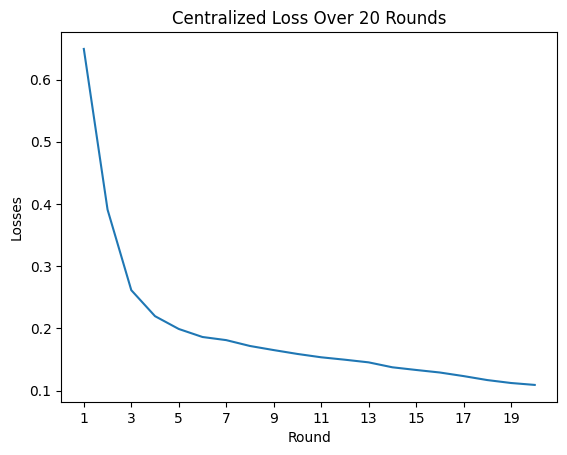

In [ ]:
print(f"{history.losses_distributed = }")

# Extract rounds and losses from the distributed losses
loss_centralised = history.losses_distributed
rounds = [int(data[0]) for data in loss_centralised]  # Cast rounds to integers
losses = [data[1] for data in loss_centralised]

# Plot the centralized loss over rounds
plt.plot(rounds, losses)
plt.ylabel("Losses")
plt.xlabel("Round")
plt.title(f'Centralized Loss Over {max(rounds)} Rounds')
plt.xticks(np.arange(min(rounds), max(rounds)+1, 2))
plt.show()


history.metrics_distributed= {'accuracy': [(1, 0.8105058365758755), (2, 0.8889105058365758), (3, 0.9083657587548638), (4, 0.9147859922178988), (5, 0.9239299610894942), (6, 0.9284046692607004), (7, 0.9249027237354086), (8, 0.9293774319066148), (9, 0.935408560311284), (10, 0.9357976653696498), (11, 0.9392996108949416), (12, 0.9406614785992218), (13, 0.9424124513618677), (14, 0.9492217898832684), (15, 0.9505836575875486), (16, 0.9521400778210116), (17, 0.9540856031128405), (18, 0.9570038910505837), (19, 0.9577821011673152), (20, 0.9585603112840467)]}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Centralized Accuracy 20 Over Rounds')

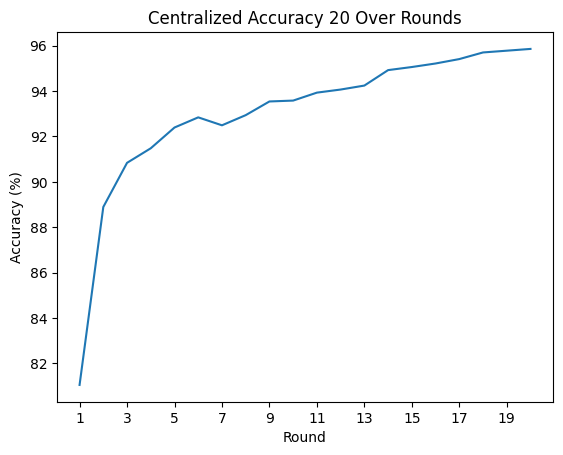

In [ ]:
print(f"{history.metrics_distributed= }")

global_accuracy_centralised = history.metrics_distributed ["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.xticks(np.arange(min(rounds), max(rounds), 2))
plt.title(f"Centralized Accuracy {max(rounds)} Over Rounds")